<a href="https://colab.research.google.com/github/arturbernardo/data_roads/blob/main/data_roads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install overpy


In [57]:
import pandas as pd
import geopandas as gpd
from shapely.ops import linemerge, unary_union


In [ ]:
import overpy

api = overpy.Overpass()
# bbox = box()  # (min_lon, min_lat, max_lon, max_lat)
# -33.0,-58.0,-27.0,-49.0
# Consulta: rodovias com ref RS-*
query = """
[out:json][timeout:25];
(
  way(around:100000, -30.0346, -51.2177)["highway"]["ref"~"ERS-"];
);
out geom;
"""

result = api.query(query)

# Iterar sobre os caminhos encontrados
for way in result.ways:
    print(way.tags.get("ref"))
    # print(way.tags.get("ref"), [(node.lat, node.lon) for node in way.nodes])


In [ ]:
result.ways

In [ ]:
import overpy
import geopandas as gpd
from shapely.geometry import LineString

api = overpy.Overpass()

query = """
[out:json][timeout:25];
(
  way(around:100000, -30.0346, -51.2177)["highway"]["ref"~"ERS-"];
);
out geom;
"""

result = api.query(query)

features = []
for way in result.ways:
    if not way.geometry or len(way.geometry) < 2:
        continue
    coords = [(pt.lon, pt.lat) for pt in way.geometry]
    line = LineString(coords)
    ref = way.tags.get("ref", "")
    name = way.tags.get("name", "")
    features.append({"ref": ref, "name": name, "geometry": line})

gdf = gpd.GeoDataFrame(features, crs="EPSG:4326")
gdf.plot()


<Axes: >

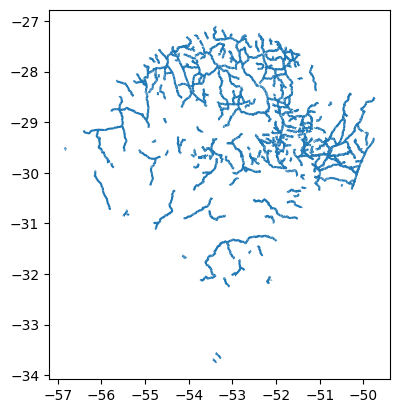

In [28]:
import requests
import geopandas as gpd
from shapely.geometry import LineString

# query = """
# [out:json][timeout:25];
# (
#   way(around:100000, -30.0346, -51.2177)["highway"]["ref"~"ERS-"];
# );
# out geom;
# """

query = """
[out:json][timeout:25];
area["name"="Rio Grande do Sul"]["admin_level"="4"]->.searchArea;
(
  way["highway"]["ref"~".RS-"](area.searchArea);
);
out geom;
"""

url = "http://overpass-api.de/api/interpreter"
response = requests.post(url, data={"data": query})
data = response.json()

features = []
for el in data["elements"]:
    if el["type"] == "way" and "geometry" in el and len(el["geometry"]) >= 2:
        coords = [(pt["lon"], pt["lat"]) for pt in el["geometry"]]
        line = LineString(coords)
        tags = el.get("tags", {})
        features.append({
            "ref": tags.get("ref", ""),
            "name": tags.get("name", ""),
            "geometry": line
        })

gdf = gpd.GeoDataFrame(features, crs="EPSG:4326")
gdf.plot()


<Axes: >

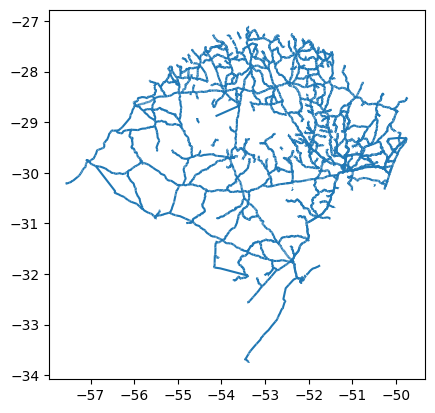

In [30]:
import requests
import geopandas as gpd
from shapely.geometry import LineString

# query = """
# [out:json][timeout:25];
# (
#   way(around:100000, -30.0346, -51.2177)["highway"]["ref"~"ERS-"];
# );
# out geom;
# """

query = """
[out:json][timeout:25];
area["name"="Rio Grande do Sul"]["admin_level"="4"]->.searchArea;
(
  way["highway"]["ref"~"^(ERS|BR)-"](area.searchArea);
);
out geom;
"""

url = "http://overpass-api.de/api/interpreter"
response = requests.post(url, data={"data": query})
data = response.json()

features = []
for el in data["elements"]:
    if el["type"] == "way" and "geometry" in el and len(el["geometry"]) >= 2:
        coords = [(pt["lon"], pt["lat"]) for pt in el["geometry"]]
        line = LineString(coords)
        tags = el.get("tags", {})
        features.append({
            "ref": tags.get("ref", ""),
            "name": tags.get("name", ""),
            "geometry": line
        })

gdf = gpd.GeoDataFrame(features, crs="EPSG:4326")
gdf.plot()


In [34]:
gdf_proj = gdf.to_crs(epsg=31982)  # SIRGAS 2000 / UTM zone 22S

# Soma o comprimento de cada linha por 'ref'
km_por_rodovia = gdf_proj.groupby("ref")["geometry"].apply(lambda x: x.length.sum() / 1000)

print(km_por_rodovia.sort_values(ascending=False))

ref
BR-116             913.905147
BR-290             701.643257
BR-285             656.878196
BR-386             490.322386
BR-293             487.019624
                      ...    
BR-481               0.002158
ERS-129;ERS-434      0.001311
ERS-142;ERS-330      0.000991
BR-481;ERS-342       0.000331
BR-163               0.000086
Name: geometry, Length: 306, dtype: float64


In [64]:
# prompt: Crie um filtro que encontra o valor relativo a BR-386 em km_por_rodovia

# Assuming km_por_rodovia is already defined as in the provided code
try:
    br386_km = km_por_rodovia["BR-386"]
    print(f"O valor relativo à BR-386 em km_por_rodovia é: {br386_km} km")
except KeyError:
    print("A rodovia BR-386 não foi encontrada no DataFrame.")


O valor relativo à BR-386 em km_por_rodovia é: 490.3223861012483 km


In [62]:
x = km_por_rodovia['ref'] == 'BR-386'
x

KeyError: 'ref'

In [55]:
gdf_proj

,ref,name,geometry
0,BR-116;BR-290,Ponte do Rio Jacuí,"LINESTRING (473069.277 6681817.727, 473648.994..."
1,BR-116,Rodovia General Bento Gonçalves,"LINESTRING (364089.383 6485520.415, 363999.551..."
2,BR-116,Rodovia General Bento Gonçalves,"LINESTRING (342453.677 6468883.202, 342372.42 ..."
3,ERS-602,,"LINESTRING (300057.644 6435864.884, 299940.237..."
4,BR-116,Rodovia General Bento Gonçalves,"LINESTRING (305036.562 6430618.931, 304994.782..."
...,...,...,...
16693,BR-386,Rodovia Governador Leonel de Moura Brizola,"LINESTRING (407594.062 6739086.066, 407593.486..."
16694,ERS-110,Rodovia Deputado Julio Redecker,"LINESTRING (569202.832 6852554.709, 569211.111..."
16695,ERS-110,Rodovia Deputado Julio Redecker,"LINESTRING (569211.111 6852552.123, 569214.635..."
16696,ERS-110,Rodovia Deputado Julio Redecker,"LINESTRING (569229.411 6852545.357, 569226.555..."


In [31]:
uri = "https://raw.githubusercontent.com/arturbernardo/data_roads/refs/heads/main/demostrativo_acidentes_viasul.csv"
!wget -U "Mozilla" -O demostrativo_acidentes_viasul.csv {uri}

--2025-05-11 00:43:54--  https://raw.githubusercontent.com/arturbernardo/data_roads/refs/heads/main/demostrativo_acidentes_viasul.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2037064 (1.9M) [application/octet-stream]
Saving to: ‘demostrativo_acidentes_viasul.csv’

demostrativo_aciden 100%[===================>]   1.94M  6.70MB/s    in 0.3s    

2025-05-11 00:43:55 (6.70 MB/s) - ‘demostrativo_acidentes_viasul.csv’ saved [2037064/2037064]



In [41]:
# Lajeado
uri = "https://drive.usercontent.google.com/download?id=1Z_rZ9yvkbTlsPJk6x2nHbC3gH5Nvb4mQ&export=download&authuser=0&confirm=t&uuid=4d7c3f0e-480c-465f-bbe5-7296390066fe&at=ALoNOgmPzwt2ByL7QmzbIfCKHo1M:1746924286095"
!wget -U "Mozilla" -O lajeado_fatais.xlsx {uri}

--2025-05-11 01:01:42--  https://drive.usercontent.google.com/download?id=1Z_rZ9yvkbTlsPJk6x2nHbC3gH5Nvb4mQ
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.174.132, 2404:6800:4008:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.174.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18827 (18K) [application/octet-stream]
Saving to: ‘lajeado_fatais.xlsx’

lajeado_fatais.xlsx 100%[===================>]  18.39K  --.-KB/s    in 0s      

2025-05-11 01:01:45 (116 MB/s) - ‘lajeado_fatais.xlsx’ saved [18827/18827]



In [33]:
from shapely.geometry import Point

def ponto_por_km(rodovia_linha, km, km_total):
    frac = km / km_total
    if frac < 0: frac = 0
    if frac > 1: frac = 1
    return rodovia_linha.interpolate(frac, normalized=True)

In [44]:
path = '/content/lajeado_fatais.xlsx'

df = pd.read_excel(path)

In [47]:
df['LOG_NORM'] = df['Logradouro'].str.upper().str.replace(' ', '-')

In [ ]:
df

In [52]:
df_filtered = df[df['LOG_NORM'].str.startswith('BR') | df['LOG_NORM'].str.startswith('RS')]

In [72]:
df_filtered = df_filtered[df_filtered['Vítimas fatais'] > 0]
df_filtered = df_filtered[df_filtered['Nº/ KM'].apply(lambda x: isinstance(x, (int, float, complex)))]


In [53]:
df_filtered

,Município,Data Ocorrencia,Ano,Mës,Dia Mês,Dia da Semana,Tipo Via,Logradouro,Nº/ KM,Natureza,Hora,Turno,Vítimas fatais,LOG_NORM,hover
0,LAJEADO,2011-01-29,2011,Jan,29,Sábado,Estadual,RS 130,65,Colisão,05:15:00,Madrugada,1,RS-130,2011-01-29<br>RS-130<br>Mortos: 1<br>Km: 65<br...
1,LAJEADO,2012-07-07,2012,Jul,7,Sábado,Estadual,RS 130,67,Tombamento,11:20:00,Manhã,1,RS-130,2012-07-07<br>RS-130<br>Mortos: 1<br>Km: 67<br...
2,LAJEADO,2012-07-24,2012,Jul,24,Terça,Estadual,RS 130,67,Colisão,14:30:00,Tarde,1,RS-130,2012-07-24<br>RS-130<br>Mortos: 1<br>Km: 67<br...
3,LAJEADO,2013-06-27,2013,Jun,27,Quinta,Estadual,RS 130,69,Colisão,16:30:00,Tarde,1,RS-130,2013-06-27<br>RS-130<br>Mortos: 1<br>Km: 69<br...
4,LAJEADO,2011-05-03,2011,Mai,3,Terça,Estadual,RS 130,70,Atropelamento,14:00:00,Tarde,1,RS-130,2011-05-03<br>RS-130<br>Mortos: 1<br>Km: 70<br...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,LAJEADO,2015-08-05,2015,Ago,5,Quarta,Federal,BR 386,347,Atropelamento,19:40:00,Noite,1,BR-386,2015-08-05<br>BR-386<br>Mortos: 1<br>Km: 347<b...
86,LAJEADO,2015-04-16,2015,Abr,16,Quinta,Federal,BR 386,347.4,Colisão Lateral,19:10:00,Noite,1,BR-386,2015-04-16<br>BR-386<br>Mortos: 1<br>Km: 347.4...
87,LAJEADO,2014-09-05,2014,Set,5,Sexta,Federal,BR 386,347.8,Atropelamento,20:25:00,Noite,1,BR-386,2014-09-05<br>BR-386<br>Mortos: 1<br>Km: 347.8...
88,LAJEADO,2010-07-25,2010,Jul,25,Domingo,Federal,BR 386,-,Choque Com Objeto Fixo,02:05:00,Madrugada,1,BR-386,2010-07-25<br>BR-386<br>Mortos: 1<br>Km: -<br>...


In [82]:
df_filtered = df_filtered[df_filtered["LOG_NORM"] == 'BR-386']

In [83]:
df_filtered

,Município,Data Ocorrencia,Ano,Mës,Dia Mês,Dia da Semana,Tipo Via,Logradouro,Nº/ KM,Natureza,Hora,Turno,Vítimas fatais,LOG_NORM,hover
41,LAJEADO,2014-09-20,2014,Set,20,Sábado,Federal,BR 386,336.8,Atropelamento,00:50:00,Madrugada,1,BR-386,2014-09-20<br>BR-386<br>Mortos: 1<br>Km: 336.8...
42,LAJEADO,2017-12-01,2017,Dez,1,Sexta,Federal,BR 386,339,Colisão,07:00:00,Manhã,1,BR-386,2017-12-01<br>BR-386<br>Mortos: 1<br>Km: 339<b...
43,LAJEADO,2013-11-28,2013,Nov,28,Quinta,Federal,BR 386,339.1,Colisão,11:25:00,Manhã,1,BR-386,2013-11-28<br>BR-386<br>Mortos: 1<br>Km: 339.1...
44,LAJEADO,2016-07-07,2016,Jul,7,Quinta,Federal,BR 386,339.1,Colisão Lateral,16:25:00,Tarde,1,BR-386,2016-07-07<br>BR-386<br>Mortos: 1<br>Km: 339.1...
45,LAJEADO,2011-02-23,2011,Fev,23,Quarta,Federal,BR 386,340,Colisão,19:30:00,Noite,1,BR-386,2011-02-23<br>BR-386<br>Mortos: 1<br>Km: 340<b...
46,LAJEADO,2016-04-29,2016,Abr,29,Sexta,Federal,BR 386,340,Colisão Lateral,18:00:00,Noite,1,BR-386,2016-04-29<br>BR-386<br>Mortos: 1<br>Km: 340<b...
47,LAJEADO,2011-10-03,2011,Out,3,Segunda,Federal,BR 386,340.8,Colisão,13:00:00,Tarde,1,BR-386,2011-10-03<br>BR-386<br>Mortos: 1<br>Km: 340.8...
48,LAJEADO,2012-11-02,2012,Nov,2,Sexta,Federal,BR 386,340.9,Colisão Lateral,06:30:00,Manhã,1,BR-386,2012-11-02<br>BR-386<br>Mortos: 1<br>Km: 340.9...
49,LAJEADO,2013-03-17,2013,Mar,17,Domingo,Federal,BR 386,341,Colisão,18:10:00,Noite,2,BR-386,2013-03-17<br>BR-386<br>Mortos: 2<br>Km: 341<b...
50,LAJEADO,2014-10-17,2014,Out,17,Sexta,Federal,BR 386,341,Colisão Lateral,07:50:00,Manhã,1,BR-386,2014-10-17<br>BR-386<br>Mortos: 1<br>Km: 341<b...


In [84]:
df_filtered["hover"] = (
    df_filtered["Data Ocorrencia"].astype(str) + "<br>" + df_filtered["LOG_NORM"]
    + "<br>" + "Mortos: " + df_filtered["Vítimas fatais"].astype(str)
    + "<br>" + "Km: " + df_filtered["Nº/ KM"].astype(str)
    + "<br>" + df_filtered["Natureza"]
)

<ipython-input-84-9e75779470b9>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
km_por_rodovia gdf_proj

In [85]:
km_por_rodovia['BR-386']

np.float64(490.3223861012483)

In [86]:
from tqdm import tqdm  # para mostrar barra de progresso

nome = 'BR-386'
acidente_coords = []
linha_rodovia = gdf_proj[gdf_proj["ref"] == nome]  # ajuste o nome da coluna
multi = unary_union(linha_rodovia.geometry)

for _, ac in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    km = ac["Nº/ KM"]

    # Seleciona a linha da rodovia correspondente
    # linha_rodovia = rodovias[rodovias["vl_br"] == nome]  # ajuste o nome da coluna
    # if linha_rodovia.empty:
    #     continue

    # linha = linha_rodovia.iloc[0].geometry
    comprimento = multi.length  # em graus (se não for projetado)

    if (isinstance(km, (int, float, complex))):
      ponto = ponto_por_km(multi, km, km_por_rodovia[nome])  # ajuste se souber o km total real
      acidente_coords.append(ponto)





100%|██████████| 47/47 [00:00<00:00, 2912.80it/s]


In [87]:
import geopandas as gpd

gdf_acidentes = gpd.GeoDataFrame(df_filtered, geometry=acidente_coords, crs=gdf_proj.crs)

In [1]:
gdf_acidentes

NameError: name 'gdf_acidentes' is not defined

In [ ]:
import plotly.graph_objects as go

# Certifique-se de que o GeoDataFrame está em WGS84 (lat/lon)
gdf_acidentes = gdf_acidentes.to_crs("EPSG:4326")

fig = go.Figure(go.Scattermapbox(
    lat=gdf_acidentes.geometry.y,
    lon=gdf_acidentes.geometry.x,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=12,
        color='red'
    ),
    hovertext=gdf_acidentes['hover'],  # coluna a exibir
    hoverinfo='text'
))

for _, row in gdf_proj.iterrows():
    lat = list(row.geometry.coords.xy[1])  # Extract y coordinates (latitude)
    lon = list(row.geometry.coords.xy[0])  # Extract x coordinates (longitude)

    fig.add_trace(go.Scattermapbox(
        lat=lat,
        lon=lon,
        mode='lines',
        line=dict(width=2, color='blue'),
        name=row.get("ref", "Rodovia"),
        hoverinfo='none'  # ou 'text' se quiser mostrar algo
    ))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": -29.4685, "lon": -51.9653},
    mapbox_zoom=12,
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


In [ ]:
!pip install pyrosm geopandas matplotlib


In [ ]:
# https://download.geofabrik.de/south-america/brazil/sul-latest.osm.pbf


In [3]:
uri = "https://download.geofabrik.de/south-america/brazil/sul-latest.osm.pbf"
# uri = "https://raw.githubusercontent.com/arturbernardo/data_roads/refs/heads/main/georoads.json"
!wget -U "Mozilla" -O sul.osm.pbf {uri}

--2025-05-10 19:48:37--  https://download.geofabrik.de/south-america/brazil/sul-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 95.217.63.98, 95.216.245.233, 95.217.45.61, ...
Connecting to download.geofabrik.de (download.geofabrik.de)|95.217.63.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 395531704 (377M) [application/octet-stream]
Saving to: ‘sul.osm.pbf’

sul.osm.pbf         100%[===================>] 377.21M  10.3MB/s    in 38s     

2025-05-10 19:49:16 (9.86 MB/s) - ‘sul.osm.pbf’ saved [395531704/395531704]



In [5]:
from pyrosm import get_data, OSM
import matplotlib.pyplot as plt
from shapely.geometry import box

bbox = box(-57.0, -33.0, -49.0, -27.0)  # (min_lon, min_lat, max_lon, max_lat)

osm = OSM("sul.osm.pbf", bounding_box=bbox)

# Extrai todas as vias (estradas, ruas, etc.)
roads = osm.get_network(network_type="driving")  # ou 'all' para todas as vias

# Plota
roads.plot(figsize=(12, 12), linewidth=0.5)
plt.title("Rodovias e estradas - Região Sul do Brasil")
plt.show()


KeyboardInterrupt: 

In [6]:
from pyrosm import OSM
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

bbox = box(-57.0, -33.0, -49.0, -27.0)  # (min_lon, min_lat, max_lon, max_lat)

osm = OSM("sul.osm.pbf", bounding_box=bbox)

# Carrega somente geometrias que tenham tag 'highway'
roads = osm.get_data_by_custom_criteria(
    custom_filter={"highway": True},
    filter_type="keep",
    osm_keys_to_keep=[],  # Não queremos colunas extras
)



/usr/local/lib/python3.11/dist-packages/pyrosm/pyrosm.py:767: UserWarning: Could not find any OSM data for given area.
  gdf = get_user_defined_data(


AttributeError: 'NoneType' object has no attribute 'head'

In [8]:
# Agora roads é bem mais leve, só com geometria
print(roads.head())  # Só deve ter 'geometry'

# Plot simples
roads.plot(figsize=(10, 10), linewidth=0.3)
plt.show()

In [5]:
from pyrosm import OSM
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box

bbox = box(-51.9698, -29.5048, -52.9698, -28.5048)  # (min_lon, min_lat, max_lon, max_lat)

osm = OSM("sul.osm.pbf", bounding_box=bbox)
osm.file_size

377.21

In [ ]:
# Se quiser uma cidade,
# você pode baixar a geometria de um município via IBGE
# ou shapefile e
# passar como polygon.

In [1]:
import pandas as pd
import geopandas as gpd


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [27]:
# import geopandas as gpd

# gdf = gpd.read_file("/content/GEOFT_TRECHO_RODOVIARIO_ESTADUAL.shp")
# print(gdf.columns)


Index(['geometry'], dtype='object')


In [28]:
# import geopandas as gpd

# # Carregue o arquivo shapefile (.shp)
# gdf = gpd.read_file("/content/GEOFT_TRECHO_RODOVIARIO_ESTADUAL.shp")

# # Exporte para GeoJSON
# gdf.to_file("rodovias_estaduais.geojson", driver="GeoJSON")


/usr/local/lib/python3.11/dist-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [29]:
# rodovias_est = gpd.read_file("/content/rodovias_estaduais.geojson")
# # rodovias = rodovias.to_crs(epsg=4674)
# rodovias_est = rodovias_est.to_crs(epsg=3857)

In [ ]:
# rodovias_est

In [ ]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(10, 10))
# rodovias_est.plot(ax=ax, color='lightgray')
# # gdf_acidentes_x.plot(ax=ax, color='red', markersize=5)
# plt.show()


In [3]:
uri = "https://gist.githubusercontent.com/jaumpedro214/8524d59a2e7791c504eda0783975bcb0/raw/810b46a61fe909ca0a8416d762928e230fe8aa8c/rodovias_federais_brasil.json"
# uri = "https://raw.githubusercontent.com/arturbernardo/data_roads/refs/heads/main/georoads.json"
!wget -U "Mozilla" -O georoads.json {uri}

--2025-05-10 19:09:56--  https://gist.githubusercontent.com/jaumpedro214/8524d59a2e7791c504eda0783975bcb0/raw/810b46a61fe909ca0a8416d762928e230fe8aa8c/rodovias_federais_brasil.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9396202 (9.0M) [text/plain]
Saving to: ‘georoads.json’

georoads.json       100%[===================>]   8.96M  57.9MB/s    in 0.2s    

2025-05-10 19:09:56 (57.9 MB/s) - ‘georoads.json’ saved [9396202/9396202]



In [4]:
uri = "https://raw.githubusercontent.com/arturbernardo/data_roads/refs/heads/main/demostrativo_acidentes_viasul.csv"
!wget -U "Mozilla" -O demostrativo_acidentes_viasul.csv {uri}

--2025-05-10 19:09:58--  https://raw.githubusercontent.com/arturbernardo/data_roads/refs/heads/main/demostrativo_acidentes_viasul.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2037064 (1.9M) [application/octet-stream]
Saving to: ‘demostrativo_acidentes_viasul.csv’

demostrativo_aciden 100%[===================>]   1.94M  --.-KB/s    in 0.07s   

2025-05-10 19:09:58 (27.7 MB/s) - ‘demostrativo_acidentes_viasul.csv’ saved [2037064/2037064]



In [5]:
# path = "/content/demostrativo_acidentes_ecosul.csv"
path = '/content/demostrativo_acidentes_viasul.csv'

df = pd.read_csv(path, sep=";",encoding="latin-1", engine='python')

In [6]:
df.columns

Index(['data', 'horario', 'n_da_ocorrencia', 'tipo_de_ocorrencia', 'km',
       'trecho', 'sentido', 'tipo_de_acidente', 'automovel', 'bicicleta',
       'caminhao', 'moto', 'onibus', 'outros', 'tracao_animal',
       'transporte_de_cargas_especiais', 'trator_maquinas', 'utilitarios',
       'ilesos', 'levemente_feridos', 'moderadamente_feridos',
       'gravemente_feridos', 'mortos'],
      dtype='object')

In [ ]:
df

In [7]:
# df['km_c'] = (
#     df['km']
#     .astype(str)
#     .str.split(',', n=1).str[0]
#     .str.replace(r'\D', '', regex=True)
#     .astype('Int64')
# )

df['km_c'] = (
    df['km']
    .astype(str)  # Assegura que os valores sejam strings
    .str.replace(r'[.,].*', '', regex=True)  # Remove tudo após o ponto ou vírgula
    .str.replace(r'\D', '', regex=True)  # Remove qualquer caractere não numérico
    .astype('Int64')  # Converte para inteiro
)

In [8]:
y = df['trecho'].unique()
print(y)

['BR-290/RS' 'BR-386/RS' 'BR-101/RS' 'BR-448/RS']


In [9]:
df_386 = df[df['trecho'] == 'BR-386/RS']

In [10]:
df_386 = df_386[df_386['mortos'] > 0]

In [11]:
x = df_386['mortos'].sum()
print(x)

177


In [ ]:
df_386

In [14]:
rodovias = gpd.read_file("/content/georoads.json")
# rodovias = rodovias.to_crs(epsg=4674)
rodovias = rodovias.to_crs(epsg=3857)

In [16]:
y = rodovias['vl_br'].unique()
print(y)

['010' '050' '158' '020' '153' '230' '210' '459' '030' '040' '101' '342'
 '364' '163' '060' '070' '307' '122' '080' '174' '104' '110' '116' '135'
 '154' '235' '423' '251' '265' '146' '222' '267' '287' '424' '352' '419'
 '476' '484' '356' '259' '404' '120' '155' '156' '369' '330' '349' '439'
 '457' '283' '428' '490' '293' '308' '453' '232' '374' '359' '242' '376'
 '402' '430' '226' '455' '285' '304' '403' '373' '316' '492' '377' '324'
 '497' '272' '343' '277' '280' '290' '456' '432' '433' '405' '406' '262'
 '407' '319' '427' '434' '282' '317' '354' '485' '361' '363' '365' '367'
 '393' '381' '383' '386' '464' '392' '401' '431' '408' '447' '414' '448'
 '409' '410' '411' '412' '470' '413' '477' '415' '478' '416' '417' '418'
 '421' '450' '420' '479' '452' '422' '425' '426' '429' '435' '436' '437'
 '438' '440' '451' '454' '458' '460' '463' '461' '462' '465' '468' '466'
 '467' '486' '469' '487' '471' '472' '473' '474' '480' '475' '481' '482'
 '483' '488' '489' '491' '493' '494' '495' '496' '4

In [17]:
rodovias = rodovias[rodovias['vl_br'] == '386']

In [ ]:
rodovias

In [18]:
from shapely.geometry import Point

def ponto_por_km(rodovia_linha, km, km_total):
    frac = km / km_total
    if frac < 0: frac = 0
    if frac > 1: frac = 1
    return rodovia_linha.interpolate(frac, normalized=True)

In [19]:
from shapely.ops import linemerge, unary_union
from shapely.geometry import LineString, MultiLineString

In [20]:
from tqdm import tqdm  # para mostrar barra de progresso

nome = '386'
acidente_coords = []
linha_rodovia = rodovias[rodovias["vl_br"] == nome]  # ajuste o nome da coluna
multi = unary_union(linha_rodovia.geometry)

for _, ac in tqdm(df_386.iterrows(), total=len(df_386)):
    km = ac["km_c"]

    # Seleciona a linha da rodovia correspondente
    # linha_rodovia = rodovias[rodovias["vl_br"] == nome]  # ajuste o nome da coluna
    # if linha_rodovia.empty:
    #     continue

    # linha = linha_rodovia.iloc[0].geometry
    comprimento = multi.length  # em graus (se não for projetado)

    # corrigindo offset da rodovia 386
    ponto = ponto_por_km(multi, km - 4.6, km_total=525)  # ajuste se souber o km total real
    acidente_coords.append(ponto)





100%|██████████| 146/146 [00:00<00:00, 4601.57it/s]


In [ ]:
acidente_coords

In [21]:
# Criar GeoDataFrame dos acidentes
import geopandas as gpd

gdf_acidentes = gpd.GeoDataFrame(df_386, geometry=acidente_coords, crs=rodovias.crs)


In [ ]:
gdf_acidentes

In [ ]:
# gdf_acidentes_x = gdf_acidentes[gdf_acidentes['tipo_de_acidente'] == 'Colisão - Frontal']

In [ ]:
# gdf_acidentes_x

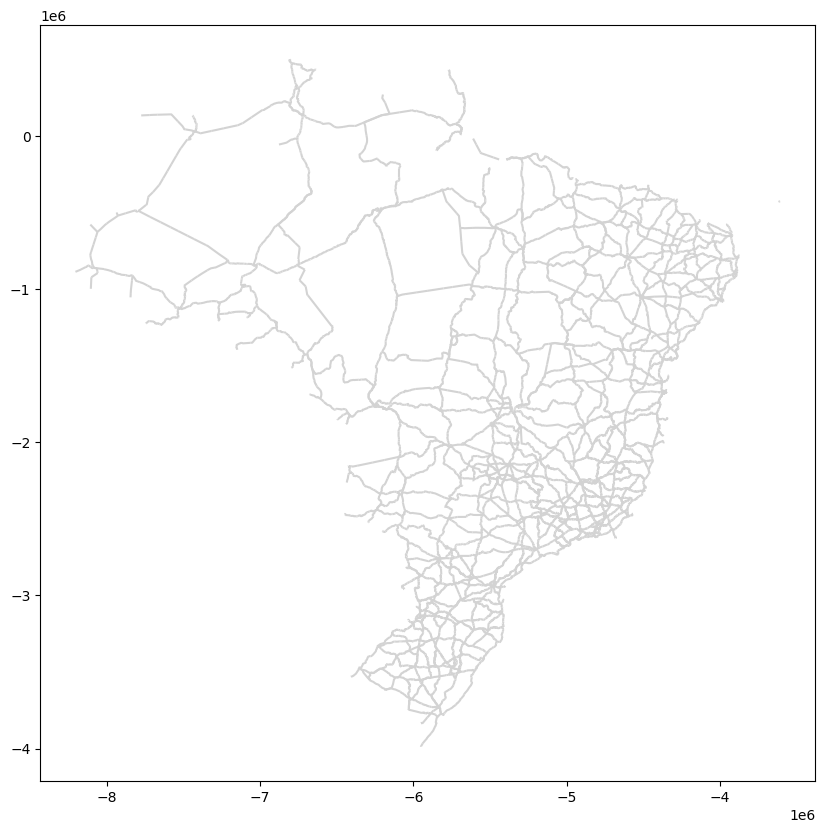

In [22]:
rodovias_all = gpd.read_file("/content/georoads.json")
# rodovias = rodovias.to_crs(epsg=4674)
rodovias_all = rodovias_all.to_crs(epsg=3857)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
rodovias_all.plot(ax=ax, color='lightgray')
# gdf_acidentes_x.plot(ax=ax, color='red', markersize=5)
plt.show()


In [ ]:
gdf_acidentes_x.geometry.x

In [ ]:
# import plotly.graph_objects as go
# gdf_acidentes_x['im_exists'] = 10
# fig = go.Figure(go.Densitymapbox(lat=gdf_acidentes_x.geometry.y, lon=gdf_acidentes_x.geometry.x, z=gdf_acidentes_x['im_exists'],
#                                  radius=5))
# fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=-51.9653, mapbox_center_lat=-29.4685)
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.update_layout(mapbox_zoom=12)
# fig.show()


# # -29.4685, Longitude: -51.9653

In [29]:
gdf_acidentes.columns

Index(['data', 'horario', 'n_da_ocorrencia', 'tipo_de_ocorrencia', 'km',
       'trecho', 'sentido', 'tipo_de_acidente', 'automovel', 'bicicleta',
       'caminhao', 'moto', 'onibus', 'outros', 'tracao_animal',
       'transporte_de_cargas_especiais', 'trator_maquinas', 'utilitarios',
       'ilesos', 'levemente_feridos', 'moderadamente_feridos',
       'gravemente_feridos', 'mortos', 'km_c', 'geometry', 'hover'],
      dtype='object')

In [49]:
gdf_acidentes["hover"] = (
    gdf_acidentes["data"].astype(str) + "<br>" + gdf_acidentes["horario"]
    + "<br>" + "Mortos: " + gdf_acidentes["mortos"].astype(str)
    + "<br>" + "Km: " + gdf_acidentes["km"].astype(str)
    + "<br>" + gdf_acidentes["tipo_de_acidente"]
    + "<br> Veículos: "
    + "<br>  - Automovel: " + gdf_acidentes["automovel"].astype(str)
    + "<br>  - Moto: " + gdf_acidentes["moto"].astype(str)
    + "<br>  - Caminhao: " + gdf_acidentes["caminhao"].astype(str)
    + "<br>  - Onibus: " + gdf_acidentes["onibus"].astype(str)
    + "<br>  - Bicicleta: " + gdf_acidentes["bicicleta"].astype(str)
)

In [50]:
import plotly.graph_objects as go

# Certifique-se de que o GeoDataFrame está em WGS84 (lat/lon)
gdf_acidentes = gdf_acidentes.to_crs("EPSG:4326")

fig = go.Figure(go.Scattermapbox(
    lat=gdf_acidentes.geometry.y,
    lon=gdf_acidentes.geometry.x,
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=12,
        color='red'
    ),
    hovertext=gdf_acidentes['hover'],  # coluna a exibir
    hoverinfo='text'
))

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_center={"lat": -29.4685, "lon": -51.9653},
    mapbox_zoom=12,
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()
